# **Packages Installation**

In [ ]:
!pip install torchtext

## **Imports**

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import time
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

# **Start with Problem 1**

In [ ]:
sequence = """Next character prediction is a fundamental task in the field of natural language
processing (NLP) that involves predicting the next character in a sequence of text
based on the characters that precede it. This task is essential for various
applications, including text auto-completion, spell checking, and even in the
development of sophisticated AI models capable of generating human-like text.
At its core, next character prediction relies on statistical models or deep learning
algorithms to analyze a given sequence of text and predict which character is most
likely to follow. These predictions are based on patterns and relationships learned
from large datasets of text during the training phase of the model.
One of the most popular approaches to next character prediction involves the use of
Recurrent Neural Networks (RNNs), and more specifically, a variant called Long
Short-Term Memory (LSTM) networks. RNNs are particularly well-suited for
sequential data like text, as they can maintain information in 'memory' about
previous characters to inform the prediction of the next character. LSTM networks
enhance this capability by being able to remember long-term dependencies, making
them even more effective for next character prediction tasks.
Training a model for next character prediction involves feeding it large amounts of
text data, allowing it to learn the probability of each character's appearance
following a sequence of characters. During this training process, the model adjusts
its parameters to minimize the difference between its predictions and the actual
outcomes, thus improving its predictive accuracy over time.
Once trained, the model can be used to predict the next character in a given piece
of text by considering the sequence of characters that precede it. This can enhance
user experience in text editing software, improve efficiency in coding environments with auto-completion features, and enable more natural interactions with AI-based
chatbots and virtual assistants.
In summary, next character prediction plays a crucial role in enhancing the
capabilities of various NLP applications, making text-based interactions more
efficient, accurate, and human-like. Through the use of advanced machine learning
models like RNNs and LSTMs, next character prediction continues to evolve, opening
new possibilities for the future of text-based technology."""


In [ ]:

unique_chars = sorted(list(set(sequence)))
char_to_index = {ch: i for i, ch in enumerate(unique_chars)}
index_to_char = {i: ch for i, ch in enumerate(unique_chars)}
input_size = output_size = len(unique_chars)


# Encoding the sequence
def encode_sequence(seq):
    return [char_to_index[char] for char in seq]

# Preparing training data
def create_training_data(sequence, seq_length):
    sequences = []
    next_chars = []
    for i in range(len(sequence) - seq_length):
        sequences.append(encode_sequence(sequence[i: i + seq_length]))
        next_chars.append(char_to_index[sequence[i + seq_length]])
    return torch.tensor(sequences, dtype=torch.long), torch.tensor(next_chars, dtype=torch.long)



def split_data(sequences, next_chars, split_ratio=0.8):
    """Splits the dataset into training and validation sets."""
    # Calculate the split index
    total_size = sequences.size(0)
    split_idx = int(total_size * split_ratio)

    # Split the sequences and next characters into training and validation sets
    train_sequences = sequences[:split_idx]
    train_next_chars = next_chars[:split_idx]
    val_sequences = sequences[split_idx:]
    val_next_chars = next_chars[split_idx:]

    return train_sequences, train_next_chars, val_sequences, val_next_chars


In [ ]:
sequences_10, next_chars_10 = create_training_data(sequence, 10)
sequences_20, next_chars_20 = create_training_data(sequence, 20)
sequences_30, next_chars_30 = create_training_data(sequence, 30)


# Apply the splitting function to your datasets
train_sequences_10, train_next_chars_10, val_sequences_10, val_next_chars_10 = split_data(sequences_10, next_chars_10)
train_sequences_20, train_next_chars_20, val_sequences_20, val_next_chars_20 = split_data(sequences_20, next_chars_20)
train_sequences_30, train_next_chars_30, val_sequences_30, val_next_chars_30 = split_data(sequences_30, next_chars_30)


# **Model Development**

## **Start with the RNN Model**

In [ ]:
# class RNNModel(nn.Module):
#     def __init__(self, vocab_size, embed_dim, hidden_size, output_size, num_layers=1):
#         super(RNNModel, self).__init__()
#         self.num_layers = num_layers
#         self.hidden_size = hidden_size
#         self.embed = nn.Embedding(vocab_size, embed_dim)
#         self.rnn = nn.RNN(embed_dim, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         # Initialize hidden state with zeros
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

#         x = self.embed(x)
#         out, _ = self.rnn(x, h0)

#         out = self.fc(out[:, -1, :])
#         return out

class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, output_size, num_layers=1):
        super(RNNModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        x = self.embed(x)
        out, _ = self.rnn(x, h0)
        out = F.relu(out[:, -1, :])
        out = self.fc(out)
        return out


class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        x = self.embed(x)
        out, _ = self.lstm(x, (h0, c0))
        out = F.relu(out[:, -1, :])
        out = self.fc(out)
        return out


class GRUModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, output_size, num_layers=1):
        super(GRUModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.gru = nn.GRU(embed_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        x = self.embed(x)
        out, _ = self.gru(x, h0)
        out = F.relu(out[:, -1, :])
        out = self.fc(out)
        return out


In [ ]:
def train_and_validate(model, train_sequences, train_next_chars, val_sequences, val_next_chars, num_epochs=500, learning_rate=0.0001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)

    # Lists to store metrics
    train_losses = []
    val_losses = []
    val_accuracies = []

    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        # Training phase
        output = model(train_sequences.to(device))
        loss = criterion(output, train_next_chars.to(device).view(-1))
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # Validation phase
        model.eval()
        total_correct = 0
        with torch.no_grad():
            val_output = model(val_sequences.to(device))
            val_loss = criterion(val_output, val_next_chars.to(device).view(-1))
            val_losses.append(val_loss.item())

            _, predicted_indices = torch.max(val_output, 1)
            total_correct = (predicted_indices == val_next_chars.to(device)).sum().item()
            accuracy = total_correct / val_sequences.size(0)
            val_accuracies.append(accuracy)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {accuracy:.4f}')

    end_time = time.time()
    training_time = end_time - start_time

    return train_losses, val_losses, val_accuracies, training_time


def plot_metrics(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs, val_accuracies, color='green', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# **Start with the RNN Model**

In [ ]:
rnn_model = RNNModel(vocab_size=input_size, embed_dim=64, hidden_size=128, output_size=output_size, num_layers=1)
lstm_model = LSTMModel(vocab_size=input_size, embed_dim=64, hidden_size=128, output_size=output_size, num_layers=1)
gru_model = GRUModel(vocab_size=input_size, embed_dim=64, hidden_size=128, output_size=output_size, num_layers=1)

Epoch [10/500], Train Loss: 3.8249, Val Loss: 3.8246, Val Accuracy: 0.0168
Epoch [20/500], Train Loss: 3.7759, Val Loss: 3.7813, Val Accuracy: 0.0399
Epoch [30/500], Train Loss: 3.7276, Val Loss: 3.7384, Val Accuracy: 0.0609
Epoch [40/500], Train Loss: 3.6788, Val Loss: 3.6947, Val Accuracy: 0.0798
Epoch [50/500], Train Loss: 3.6279, Val Loss: 3.6488, Val Accuracy: 0.1218
Epoch [60/500], Train Loss: 3.5738, Val Loss: 3.5993, Val Accuracy: 0.1450
Epoch [70/500], Train Loss: 3.5148, Val Loss: 3.5444, Val Accuracy: 0.1723
Epoch [80/500], Train Loss: 3.4487, Val Loss: 3.4823, Val Accuracy: 0.1912
Epoch [90/500], Train Loss: 3.3742, Val Loss: 3.4112, Val Accuracy: 0.2059
Epoch [100/500], Train Loss: 3.2927, Val Loss: 3.3329, Val Accuracy: 0.2038
Epoch [110/500], Train Loss: 3.2112, Val Loss: 3.2558, Val Accuracy: 0.2080
Epoch [120/500], Train Loss: 3.1376, Val Loss: 3.1896, Val Accuracy: 0.2101
Epoch [130/500], Train Loss: 3.0759, Val Loss: 3.1375, Val Accuracy: 0.2185
Epoch [140/500], Trai

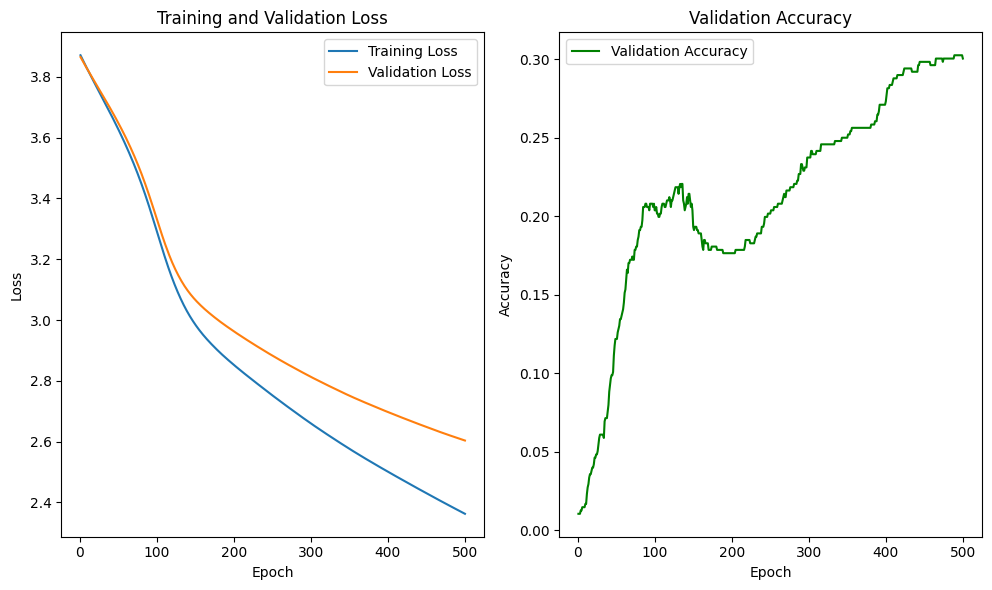

Training Time: 2.8688666820526123 seconds


In [ ]:
results_10 = train_and_validate(rnn_model, train_sequences_10, train_next_chars_10, val_sequences_10, val_next_chars_10)
train_losses, val_losses, val_accuracies, training_time = results_10
plot_metrics(train_losses, val_losses, val_accuracies)
print(f"Training Time: {training_time} seconds")

Epoch [10/500], Train Loss: 2.3528, Val Loss: 2.5933, Val Accuracy: 0.3017
Epoch [20/500], Train Loss: 2.3369, Val Loss: 2.5830, Val Accuracy: 0.3017
Epoch [30/500], Train Loss: 2.3211, Val Loss: 2.5727, Val Accuracy: 0.3059
Epoch [40/500], Train Loss: 2.3053, Val Loss: 2.5626, Val Accuracy: 0.3101
Epoch [50/500], Train Loss: 2.2897, Val Loss: 2.5525, Val Accuracy: 0.3143
Epoch [60/500], Train Loss: 2.2741, Val Loss: 2.5425, Val Accuracy: 0.3143
Epoch [70/500], Train Loss: 2.2585, Val Loss: 2.5324, Val Accuracy: 0.3207
Epoch [80/500], Train Loss: 2.2429, Val Loss: 2.5225, Val Accuracy: 0.3228
Epoch [90/500], Train Loss: 2.2274, Val Loss: 2.5127, Val Accuracy: 0.3228
Epoch [100/500], Train Loss: 2.2119, Val Loss: 2.5030, Val Accuracy: 0.3354
Epoch [110/500], Train Loss: 2.1965, Val Loss: 2.4938, Val Accuracy: 0.3354
Epoch [120/500], Train Loss: 2.1812, Val Loss: 2.4847, Val Accuracy: 0.3354
Epoch [130/500], Train Loss: 2.1660, Val Loss: 2.4757, Val Accuracy: 0.3354
Epoch [140/500], Trai

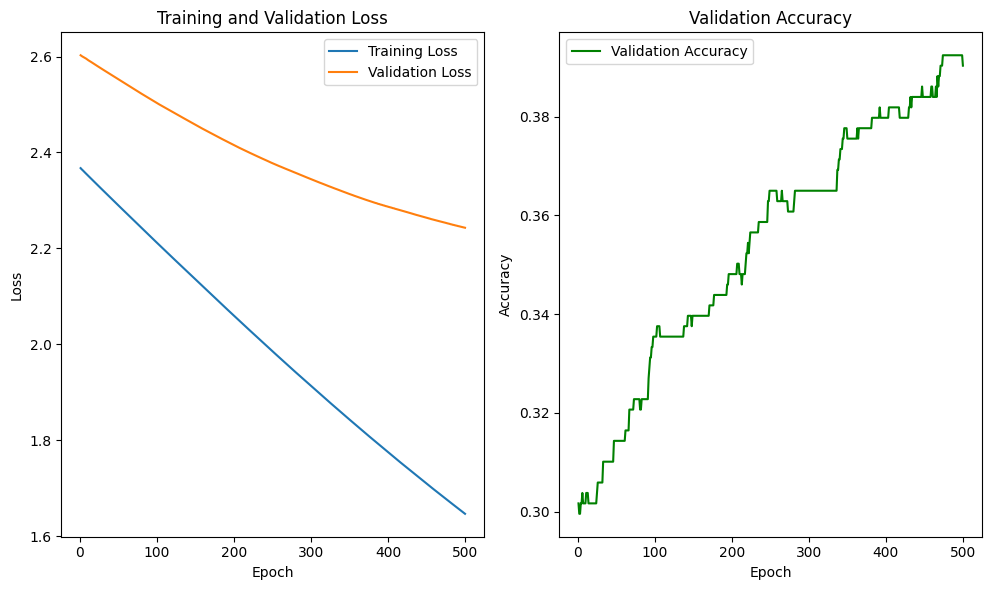

Training Time: 2.1117262840270996 seconds


In [ ]:
results_20 = train_and_validate(rnn_model, train_sequences_20, train_next_chars_20, val_sequences_20, val_next_chars_20)
train_losses, val_losses, val_accuracies, training_time = results_20
plot_metrics(train_losses, val_losses, val_accuracies)
print(f"Training Time: {training_time} seconds")

Epoch [10/500], Train Loss: 1.6394, Val Loss: 2.2451, Val Accuracy: 0.3898
Epoch [20/500], Train Loss: 1.6291, Val Loss: 2.2417, Val Accuracy: 0.3919
Epoch [30/500], Train Loss: 1.6188, Val Loss: 2.2385, Val Accuracy: 0.3962
Epoch [40/500], Train Loss: 1.6084, Val Loss: 2.2352, Val Accuracy: 0.3983
Epoch [50/500], Train Loss: 1.5979, Val Loss: 2.2320, Val Accuracy: 0.3983
Epoch [60/500], Train Loss: 1.5873, Val Loss: 2.2287, Val Accuracy: 0.4004
Epoch [70/500], Train Loss: 1.5767, Val Loss: 2.2256, Val Accuracy: 0.4025
Epoch [80/500], Train Loss: 1.5660, Val Loss: 2.2226, Val Accuracy: 0.4025
Epoch [90/500], Train Loss: 1.5554, Val Loss: 2.2196, Val Accuracy: 0.4025
Epoch [100/500], Train Loss: 1.5447, Val Loss: 2.2169, Val Accuracy: 0.4068
Epoch [110/500], Train Loss: 1.5341, Val Loss: 2.2145, Val Accuracy: 0.4110
Epoch [120/500], Train Loss: 1.5235, Val Loss: 2.2120, Val Accuracy: 0.4131
Epoch [130/500], Train Loss: 1.5128, Val Loss: 2.2096, Val Accuracy: 0.4131
Epoch [140/500], Trai

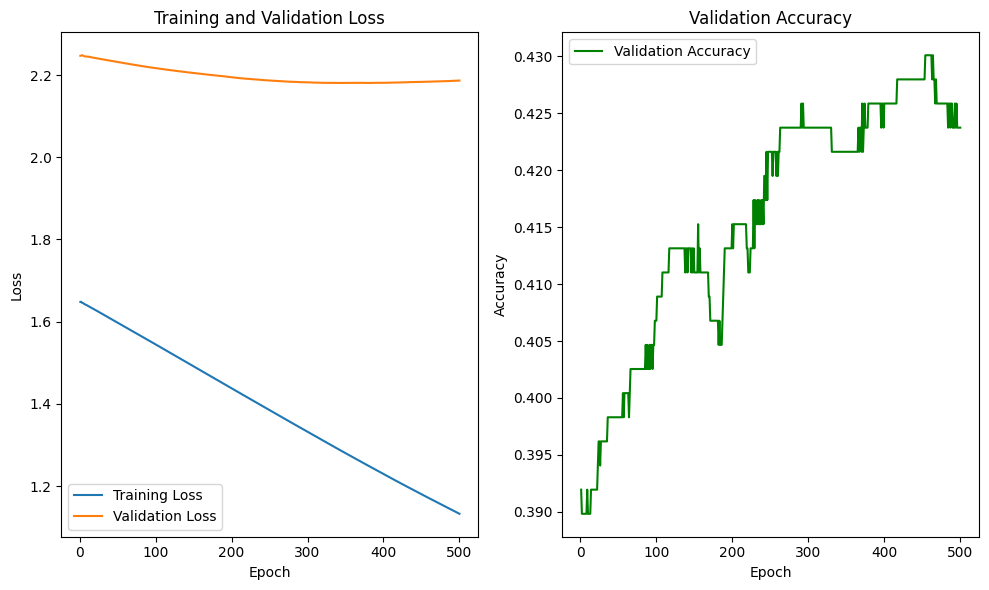

Training Time: 2.283724784851074 seconds


In [ ]:
results_30 = train_and_validate(rnn_model, train_sequences_30, train_next_chars_30, val_sequences_30, val_next_chars_30)
train_losses, val_losses, val_accuracies, training_time = results_30
plot_metrics(train_losses, val_losses, val_accuracies)
print(f"Training Time: {training_time} seconds")

# **Next With the LSTM Model**

Epoch [10/500], Train Loss: 3.7939, Val Loss: 3.7912, Val Accuracy: 0.0567
Epoch [20/500], Train Loss: 3.7760, Val Loss: 3.7754, Val Accuracy: 0.0630
Epoch [30/500], Train Loss: 3.7573, Val Loss: 3.7587, Val Accuracy: 0.0819
Epoch [40/500], Train Loss: 3.7367, Val Loss: 3.7401, Val Accuracy: 0.0987
Epoch [50/500], Train Loss: 3.7128, Val Loss: 3.7183, Val Accuracy: 0.1218
Epoch [60/500], Train Loss: 3.6830, Val Loss: 3.6912, Val Accuracy: 0.1429
Epoch [70/500], Train Loss: 3.6441, Val Loss: 3.6555, Val Accuracy: 0.1345
Epoch [80/500], Train Loss: 3.5896, Val Loss: 3.6051, Val Accuracy: 0.1345
Epoch [90/500], Train Loss: 3.5107, Val Loss: 3.5324, Val Accuracy: 0.1282
Epoch [100/500], Train Loss: 3.4014, Val Loss: 3.4316, Val Accuracy: 0.1261
Epoch [110/500], Train Loss: 3.2756, Val Loss: 3.3172, Val Accuracy: 0.1239
Epoch [120/500], Train Loss: 3.1708, Val Loss: 3.2266, Val Accuracy: 0.1218
Epoch [130/500], Train Loss: 3.1068, Val Loss: 3.1766, Val Accuracy: 0.1218
Epoch [140/500], Trai

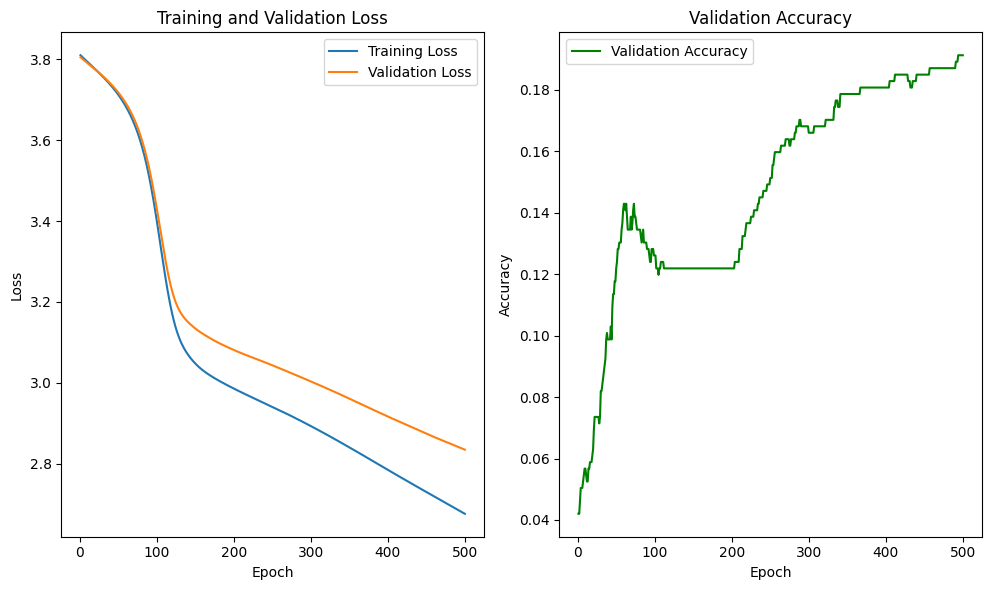

Training Time: 3.5650956630706787 seconds


In [ ]:
results_10 = train_and_validate(lstm_model, train_sequences_10, train_next_chars_10, val_sequences_10, val_next_chars_10)
train_losses, val_losses, val_accuracies, training_time = results_10
plot_metrics(train_losses, val_losses, val_accuracies)
print(f"Training Time: {training_time} seconds")

Epoch [10/500], Train Loss: 2.6740, Val Loss: 2.8276, Val Accuracy: 0.1941
Epoch [20/500], Train Loss: 2.6625, Val Loss: 2.8188, Val Accuracy: 0.1962
Epoch [30/500], Train Loss: 2.6513, Val Loss: 2.8112, Val Accuracy: 0.1983
Epoch [40/500], Train Loss: 2.6403, Val Loss: 2.8033, Val Accuracy: 0.1983
Epoch [50/500], Train Loss: 2.6294, Val Loss: 2.7954, Val Accuracy: 0.1983
Epoch [60/500], Train Loss: 2.6186, Val Loss: 2.7878, Val Accuracy: 0.2004
Epoch [70/500], Train Loss: 2.6079, Val Loss: 2.7802, Val Accuracy: 0.2004
Epoch [80/500], Train Loss: 2.5971, Val Loss: 2.7726, Val Accuracy: 0.2089
Epoch [90/500], Train Loss: 2.5861, Val Loss: 2.7649, Val Accuracy: 0.2131
Epoch [100/500], Train Loss: 2.5750, Val Loss: 2.7573, Val Accuracy: 0.2173
Epoch [110/500], Train Loss: 2.5637, Val Loss: 2.7497, Val Accuracy: 0.2215
Epoch [120/500], Train Loss: 2.5523, Val Loss: 2.7419, Val Accuracy: 0.2215
Epoch [130/500], Train Loss: 2.5407, Val Loss: 2.7339, Val Accuracy: 0.2321
Epoch [140/500], Trai

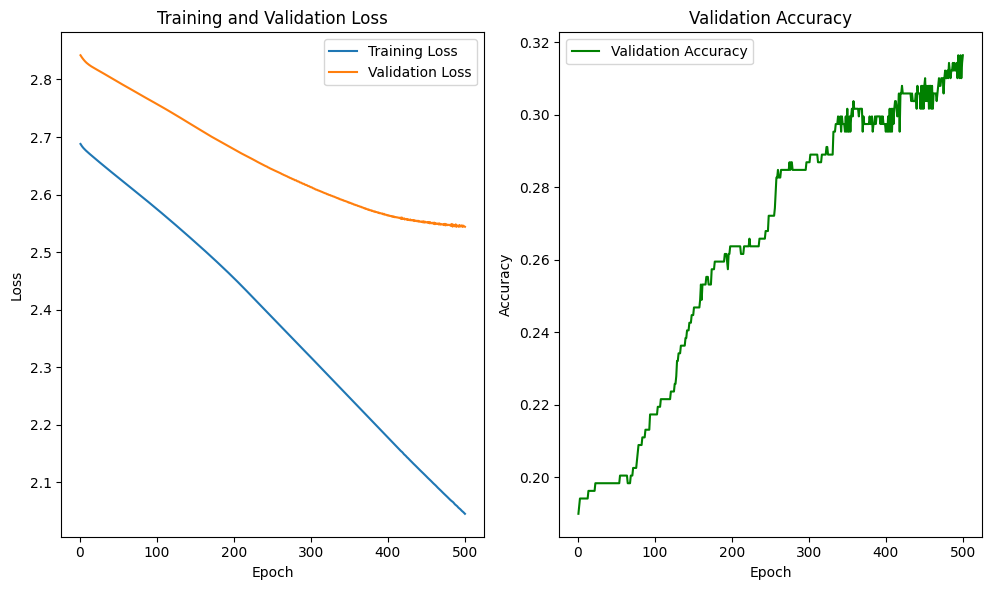

Training Time: 4.766701936721802 seconds


In [ ]:
results_20 = train_and_validate(lstm_model, train_sequences_20, train_next_chars_20, val_sequences_20, val_next_chars_20)
train_losses, val_losses, val_accuracies, training_time = results_20
plot_metrics(train_losses, val_losses, val_accuracies)
print(f"Training Time: {training_time} seconds")

Epoch [10/500], Train Loss: 2.0885, Val Loss: 2.5502, Val Accuracy: 0.3051
Epoch [20/500], Train Loss: 2.0727, Val Loss: 2.5466, Val Accuracy: 0.3093
Epoch [30/500], Train Loss: 2.0600, Val Loss: 2.5419, Val Accuracy: 0.3072
Epoch [40/500], Train Loss: 2.0493, Val Loss: 2.5377, Val Accuracy: 0.3114
Epoch [50/500], Train Loss: 2.0400, Val Loss: 2.5345, Val Accuracy: 0.3136
Epoch [60/500], Train Loss: 2.0315, Val Loss: 2.5317, Val Accuracy: 0.3178
Epoch [70/500], Train Loss: 2.0232, Val Loss: 2.5295, Val Accuracy: 0.3178
Epoch [80/500], Train Loss: 2.0150, Val Loss: 2.5282, Val Accuracy: 0.3178
Epoch [90/500], Train Loss: 2.0069, Val Loss: 2.5271, Val Accuracy: 0.3220
Epoch [100/500], Train Loss: 1.9988, Val Loss: 2.5260, Val Accuracy: 0.3220
Epoch [110/500], Train Loss: 1.9907, Val Loss: 2.5251, Val Accuracy: 0.3220
Epoch [120/500], Train Loss: 1.9826, Val Loss: 2.5242, Val Accuracy: 0.3263
Epoch [130/500], Train Loss: 1.9744, Val Loss: 2.5234, Val Accuracy: 0.3263
Epoch [140/500], Trai

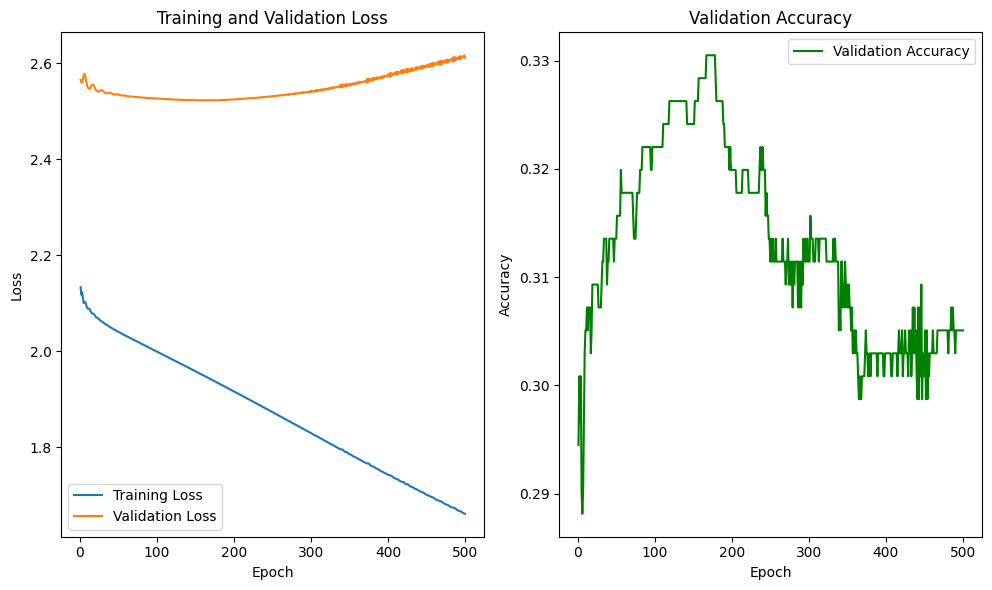

Training Time: 6.009488821029663 seconds


In [ ]:
results_30 = train_and_validate(lstm_model, train_sequences_30, train_next_chars_30, val_sequences_30, val_next_chars_30)
train_losses, val_losses, val_accuracies, training_time = results_30
plot_metrics(train_losses, val_losses, val_accuracies)
print(f"Training Time: {training_time} seconds")

# **End with the GRU Model**

Epoch [10/500], Train Loss: 3.8029, Val Loss: 3.8061, Val Accuracy: 0.0147
Epoch [20/500], Train Loss: 3.7739, Val Loss: 3.7802, Val Accuracy: 0.0273
Epoch [30/500], Train Loss: 3.7438, Val Loss: 3.7533, Val Accuracy: 0.0525
Epoch [40/500], Train Loss: 3.7116, Val Loss: 3.7244, Val Accuracy: 0.0840
Epoch [50/500], Train Loss: 3.6760, Val Loss: 3.6924, Val Accuracy: 0.1008
Epoch [60/500], Train Loss: 3.6355, Val Loss: 3.6557, Val Accuracy: 0.1176
Epoch [70/500], Train Loss: 3.5883, Val Loss: 3.6123, Val Accuracy: 0.1429
Epoch [80/500], Train Loss: 3.5314, Val Loss: 3.5595, Val Accuracy: 0.1492
Epoch [90/500], Train Loss: 3.4614, Val Loss: 3.4942, Val Accuracy: 0.1408
Epoch [100/500], Train Loss: 3.3760, Val Loss: 3.4149, Val Accuracy: 0.1239
Epoch [110/500], Train Loss: 3.2773, Val Loss: 3.3246, Val Accuracy: 0.1113
Epoch [120/500], Train Loss: 3.1799, Val Loss: 3.2389, Val Accuracy: 0.1071
Epoch [130/500], Train Loss: 3.1046, Val Loss: 3.1766, Val Accuracy: 0.1282
Epoch [140/500], Trai

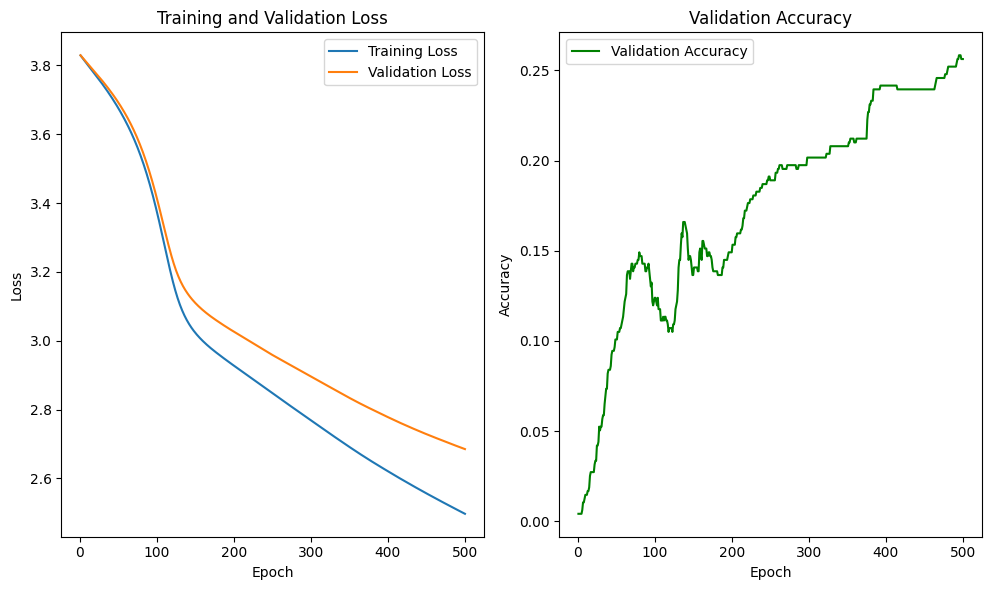

Training Time: 2.7046449184417725 seconds


In [ ]:
results_10 = train_and_validate(gru_model, train_sequences_10, train_next_chars_10, val_sequences_10, val_next_chars_10)
train_losses, val_losses, val_accuracies, training_time = results_10
plot_metrics(train_losses, val_losses, val_accuracies)
print(f"Training Time: {training_time} seconds")

Epoch [10/500], Train Loss: 1.7685, Val Loss: 2.5383, Val Accuracy: 0.3186
Epoch [20/500], Train Loss: 1.7311, Val Loss: 2.5175, Val Accuracy: 0.3207
Epoch [30/500], Train Loss: 1.7085, Val Loss: 2.5080, Val Accuracy: 0.3249
Epoch [40/500], Train Loss: 1.6930, Val Loss: 2.5083, Val Accuracy: 0.3270
Epoch [50/500], Train Loss: 1.6804, Val Loss: 2.5081, Val Accuracy: 0.3291
Epoch [60/500], Train Loss: 1.6691, Val Loss: 2.5106, Val Accuracy: 0.3270
Epoch [70/500], Train Loss: 1.6587, Val Loss: 2.5124, Val Accuracy: 0.3228
Epoch [80/500], Train Loss: 1.6489, Val Loss: 2.5148, Val Accuracy: 0.3228
Epoch [90/500], Train Loss: 1.6394, Val Loss: 2.5168, Val Accuracy: 0.3249
Epoch [100/500], Train Loss: 1.6300, Val Loss: 2.5213, Val Accuracy: 0.3228
Epoch [110/500], Train Loss: 1.6208, Val Loss: 2.5200, Val Accuracy: 0.3228
Epoch [120/500], Train Loss: 1.6116, Val Loss: 2.5248, Val Accuracy: 0.3249
Epoch [130/500], Train Loss: 1.6026, Val Loss: 2.5247, Val Accuracy: 0.3207
Epoch [140/500], Trai

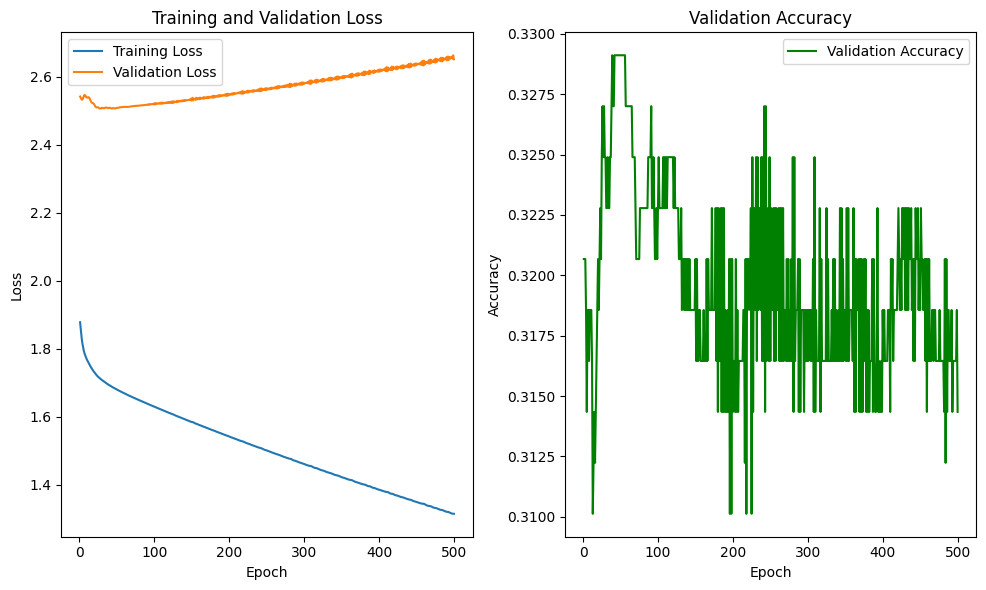

Training Time: 4.592850685119629 seconds


In [ ]:
results_20 = train_and_validate(lstm_model, train_sequences_20, train_next_chars_20, val_sequences_20, val_next_chars_20)
train_losses, val_losses, val_accuracies, training_time = results_20
plot_metrics(train_losses, val_losses, val_accuracies)
print(f"Training Time: {training_time} seconds")

Epoch [10/500], Train Loss: 1.8904, Val Loss: 2.7830, Val Accuracy: 0.2669
Epoch [20/500], Train Loss: 1.7082, Val Loss: 2.7141, Val Accuracy: 0.2966
Epoch [30/500], Train Loss: 1.6100, Val Loss: 2.6742, Val Accuracy: 0.2987
Epoch [40/500], Train Loss: 1.5588, Val Loss: 2.6380, Val Accuracy: 0.3093
Epoch [50/500], Train Loss: 1.5158, Val Loss: 2.6268, Val Accuracy: 0.3220
Epoch [60/500], Train Loss: 1.4813, Val Loss: 2.6244, Val Accuracy: 0.3178
Epoch [70/500], Train Loss: 1.4536, Val Loss: 2.6242, Val Accuracy: 0.3199
Epoch [80/500], Train Loss: 1.4323, Val Loss: 2.6293, Val Accuracy: 0.3178
Epoch [90/500], Train Loss: 1.4160, Val Loss: 2.6363, Val Accuracy: 0.3093
Epoch [100/500], Train Loss: 1.4027, Val Loss: 2.6428, Val Accuracy: 0.3157
Epoch [110/500], Train Loss: 1.3917, Val Loss: 2.6492, Val Accuracy: 0.3157
Epoch [120/500], Train Loss: 1.3821, Val Loss: 2.6539, Val Accuracy: 0.3136
Epoch [130/500], Train Loss: 1.3735, Val Loss: 2.6579, Val Accuracy: 0.3157
Epoch [140/500], Trai

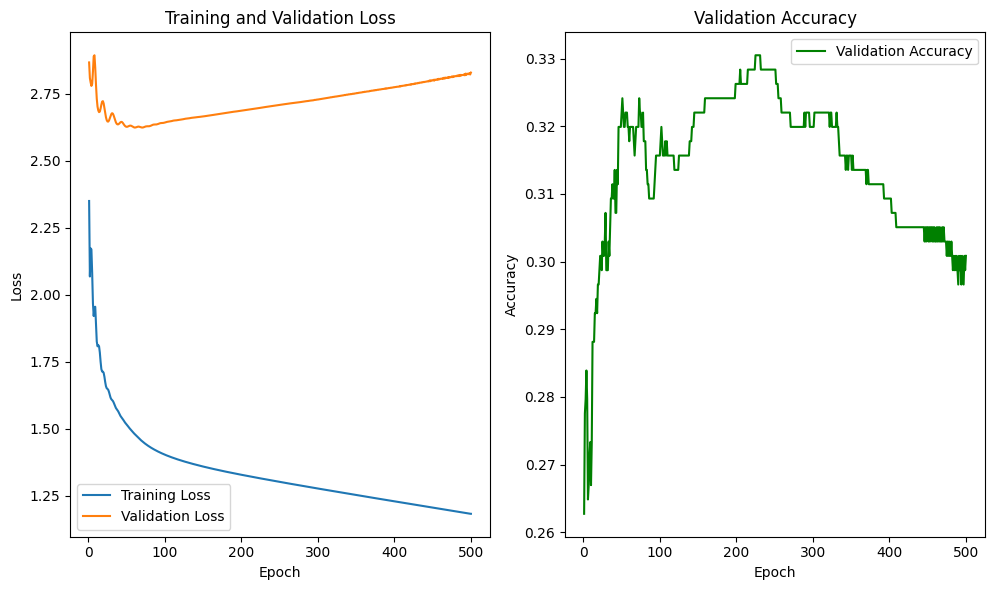

Training Time: 5.704885721206665 seconds


In [ ]:
results_30 = train_and_validate(lstm_model, train_sequences_30, train_next_chars_30, val_sequences_30, val_next_chars_30)
train_losses, val_losses, val_accuracies, training_time = results_30
plot_metrics(train_losses, val_losses, val_accuracies)
print(f"Training Time: {training_time} seconds")